# Inference Notebook
This notebook runs the backend without the Gradio UI.
It loads scenes from pickle files, renders backends locally, and runs the inference.

In [1]:
import os
os.environ["GRADIO_TMP_DIR"]="./inference/gradio_tmp" 
os.environ["GRADIO_TEMP_DIR"]="./inference/gradio_tmp" 
os.environ["TEMPDIR"]="./inference/gradio_tmp" 
os.environ["TMP_DIR"]="./inference/gradio_tmp" 
os.environ["TEMP_DIR"]="./inference/gradio_tmp" 
os.environ["TMPDIR"]="./inference/gradio_tmp" 
os.environ["CUDA_VISIBLE_DEVICES"]="1," 
import sys
import json
import time
import shutil
import subprocess
from PIL import Image
from IPython.display import display


from inference.infer_backend import initialize_inference_engine, run_inference_from_gradio
from inference.app import SceneManager, get_call_ids_from_placeholder_prompt_flux, tokenizer 
import inference.config as config


/ssd_scratch/miniconda3/envs/st3d/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


### 1. Global Scene Configs

In [8]:
SCENE_PICKLE_PATHS = [
    "inference/saved_scenes/example2.pkl"
]


### 2. Start Blender Backend Servers
Run launch_blender_backend.sh locally using Popen

In [9]:
from urllib.parse import urlparse
import inference.config as config

cv_port = urlparse(config.BLENDER_CV_SERVER_URL).port
final_port = urlparse(config.BLENDER_FINAL_SERVER_URL).port
seg_port = urlparse(config.BLENDER_SEGMASK_SERVER_URL).port

print(f"Starting Blender backends on ports: CV={cv_port}, Final={final_port}, Seg={seg_port}, Paper=5004...")
blender_process = subprocess.Popen(
    ["bash", "./launch_blender_backend.sh", str(cv_port), str(final_port), str(seg_port), "5004"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    cwd=os.path.join(os.getcwd(), "inference")
)

print("Waiting 15 seconds for servers to initialize...")
time.sleep(15)


Starting Blender backends on ports: CV=5001, Final=5002, Seg=5003, Paper=5004...
Waiting 15 seconds for servers to initialize...


### 3. Initialize Model

In [10]:
engine = initialize_inference_engine(base_model_path="black-forest-labs/FLUX.1-dev")


### 4. Scene Processing Logic

In [14]:
def process_scene(pkl_path, checkpoint_name):
    print(f"\n{'='*80}\nProcessing scene from: {pkl_path}\n{'='*80}")
    
    # Load Scene
    scene_manager = SceneManager()
    success, num_objects, error = scene_manager.load_scene_from_pkl(pkl_path)
    if not success:
        print(f"Error loading scene: {error}")
        return None
        
    print(f"Loaded {num_objects} objects.")
    
    # Prepare prompts and placeholders
    surrounding_prompt = scene_manager.surrounding_prompt
    subject_descriptions = [obj['description'] for obj in scene_manager.objects]
    
    placeholder_prompt = "a photo of PLACEHOLDER " + surrounding_prompt 
    subject_embeds = [] 
    for subject_desc in subject_descriptions: 
        input_ids = tokenizer.encode(subject_desc, return_tensors="pt", max_length=77)[0] 
        subject_embed = {"input_ids_t5": input_ids.tolist()} 
        subject_embeds.append(subject_embed)

    placeholder_text = ""
    for subject in subject_descriptions[:-1]:
        placeholder_text = placeholder_text + f"<placeholder> {subject} and "
    for subject in subject_descriptions[-1:]:
        placeholder_text = placeholder_text + f"<placeholder> {subject}"
    placeholder_text = placeholder_text.strip()

    placeholder_token_prompt = placeholder_prompt.replace("PLACEHOLDER", placeholder_text) 

    # Get Call IDs
    call_ids = get_call_ids_from_placeholder_prompt_flux(
        prompt=placeholder_token_prompt, 
        subjects=subject_descriptions, 
        subjects_embeds=subject_embeds,
        debug=False
    )
    
    # Render Blender Views
    subjects_data, camera_data = scene_manager._convert_to_blender_format()
    
    print("Rendering final view...")
    final_img = scene_manager.render_client._send_render_request(
        scene_manager.render_client.final_server_url, 
        subjects_data, 
        camera_data
    )
    
    if final_img is None:
        print("Error rendering final view (Ensure cycles server is running correctly).")
        return None
    else:
        print("CV Render received.")
        
    print("Rendering segmentation masks...")
    success, segmask_images, error_msg = scene_manager.render_client.render_segmasks(subjects_data, camera_data)
    if not success:
        print(f"Failed to render segmasks: {error_msg}")
        # Sometimes it depends on backend state, but let's continue if it fails? 
        # Better to return None as downstream needs them.
        return None
        
    # Save Rendering Results for Inference
    root_save_dir = config.GRADIO_FILES_DIR
    os.makedirs(root_save_dir, exist_ok=True)
    os.system(f"rm -f {root_save_dir}/*") 
    
    final_render_path = os.path.join(root_save_dir, "cv_render.jpg")
    final_img.save(final_render_path)
    
    for subject_idx in range(len(subject_descriptions)): 
        shutil.move(
            f"inference/{str(subject_idx).zfill(3)}_segmask_cv.png", 
            os.path.join(root_save_dir, f"main__segmask_{str(subject_idx).zfill(3)}__{1.00:.2f}.png")
        ) 
        
    # Create cuboids JSONL for dataloader
    jsonl = [{
        "cv": final_render_path,
        "target": final_render_path,
        "cuboids_segmasks": [
            os.path.join(root_save_dir, f"main__segmask_{str(subject_idx).zfill(3)}__{1.00:.2f}.png") 
            for subject_idx in range(len(subject_descriptions))
        ],
        "PLACEHOLDER_prompts": placeholder_prompt, 
        "subjects": subject_descriptions, 
        "call_ids": call_ids, 
    }] 
    
    jsonl_path = os.path.join(root_save_dir, "cuboids.jsonl")
    with open(jsonl_path, "w") as f: 
        json.dump(jsonl[0], f)
        
    # Fetch generation parameters
    params = scene_manager.inference_params
    # image_size = params.get('height', 512)
    image_size = 1024 
    seed = params.get('seed', 42)
    guidance_scale = params.get('guidance_scale', 3.5)
    num_steps = params.get('num_inference_steps', 25)
    
    print("\nRunning Diffusion Inference...")
    success, generated_image, msg = run_inference_from_gradio(
        checkpoint_name=checkpoint_name,
        height=image_size,
        width=image_size,
        seed=seed,
        guidance_scale=guidance_scale,
        num_inference_steps=num_steps,
        jsonl_path=jsonl_path
    )
    
    if success:
        print("Inference complete!")
        return generated_image
    else:
        print(f"Inference failed: {msg}")


### 5. Visualizing OSCR 
Inspect the rendered Blender image, segmentation masks, and prompt **before** running inference.

Rendering Blender scene for visualization...
passing subjects_data = [{'subject_name': 'mars rover', 'x': 1.5, 'y': 0.0, 'z': 0.0, 'azimuth': -119.99999999999999, 'width': 1.5, 'depth': 1.8, 'height': 1.0, 'base_color': (1.0, 0.0, 0.0)}, {'subject_name': 'astronaut', 'x': 0.0, 'y': -0.8, 'z': 0.0, 'azimuth': -50.0, 'width': 0.9226661026477814, 'depth': 0.8035905063152313, 'height': 1.9970132298767567, 'base_color': (0.0, 0.0, 1.0)}, {'subject_name': 'alien standing on ground', 'x': -0.20000000000000018, 'y': 0.5, 'z': 0.0, 'azimuth': -119.99999999999999, 'width': 0.6458662718534469, 'depth': 0.5625133544206619, 'height': 1.3979092609137296, 'base_color': (0.0, 1.0, 0.0)}, {'subject_name': 'spaceship', 'x': -5.0, 'y': -0.6, 'z': 1.5, 'azimuth': 0.0, 'width': 1.311025321483612, 'depth': 2.9971921741962433, 'height': 0.9849265515804291, 'base_color': (0.5, 0.0, 0.5)}, {'subject_name': 'blue neon robotic dog with slight glow', 'x': 2.7, 'y': 0.5, 'z': 0.0, 'azimuth': 29.999999999999996, 'w

/tmp/ipykernel_2832628/1930329061.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


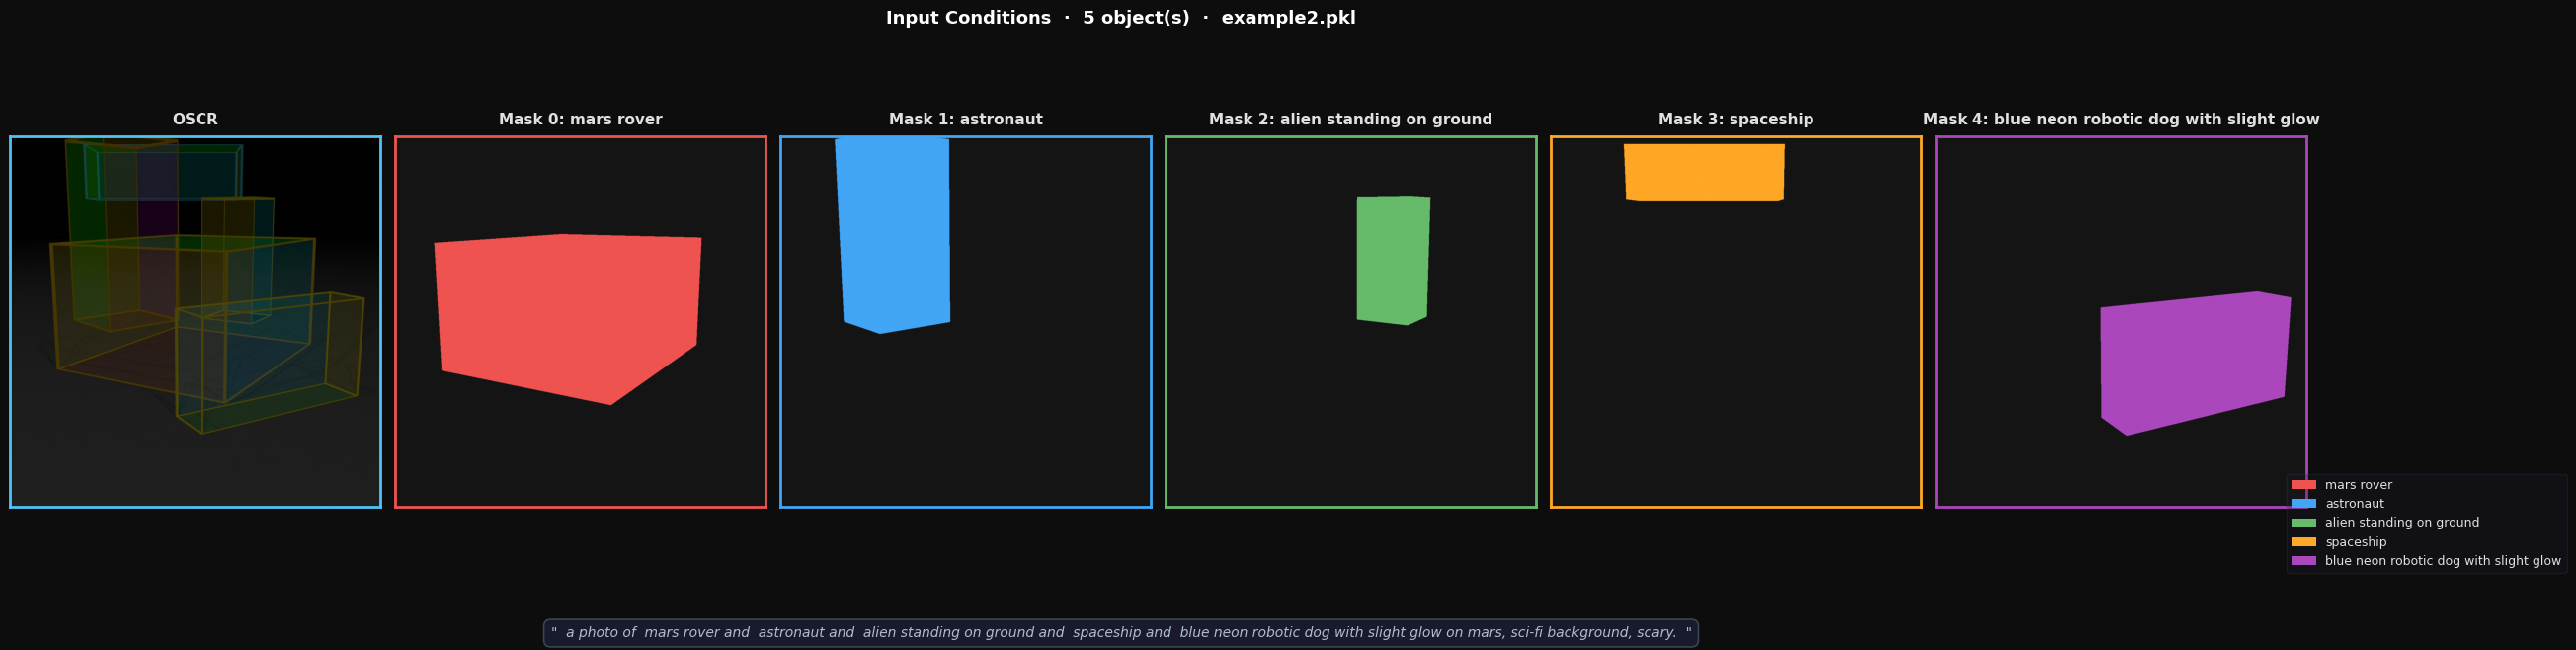


Full prompt:
  a photo of <placeholder> mars rover and <placeholder> astronaut and <placeholder> alien standing on ground and <placeholder> spaceship and <placeholder> blue neon robotic dog with slight glow on mars, sci-fi background, scary.



In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np


def visualize_input_conditions(pkl_path):
    """Render the Blender scene and segmentation masks for a given pickle and display."""

    # ── 1. Load scene ────────────────────────────────────────────────────────
    sm = SceneManager()
    success, num_objects, error = sm.load_scene_from_pkl(pkl_path)
    if not success:
        print(f"Error loading scene: {error}")
        return

    subject_descriptions = [obj['description'] for obj in sm.objects]
    surrounding_prompt   = sm.surrounding_prompt

    # ── 2. Build the full placeholder prompt ─────────────────────────────────
    placeholder_text = ""
    for subject in subject_descriptions[:-1]:
        placeholder_text += f"<placeholder> {subject} and "
    for subject in subject_descriptions[-1:]:
        placeholder_text += f"<placeholder> {subject}"
    placeholder_text = placeholder_text.strip()
    base_prompt = "a photo of PLACEHOLDER " + surrounding_prompt
    full_prompt = base_prompt.replace("PLACEHOLDER", placeholder_text)

    # ── 3. Render via Blender ─────────────────────────────────────────────────
    subjects_data, camera_data = sm._convert_to_blender_format()

    print("Rendering Blender scene for visualization...")
    final_img = sm.render_client._send_render_request(
        sm.render_client.final_server_url, subjects_data, camera_data
    )
    if final_img is None:
        print("Could not render final view – is the Blender backend running?")
        return

    print("Rendering segmentation masks...")
    ok, segmask_images, err_msg = sm.render_client.render_segmasks(subjects_data, camera_data)
    if not ok:
        print(f"Could not render segmentation masks: {err_msg}")
        segmask_images = []

    n_masks = len(segmask_images)

    # ── 4. Figure layout ──────────────────────────────────────────────────────
    # Columns: render | mask_0 | mask_1 | … | mask_N
    n_cols = 1 + max(n_masks, 1)
    fig, axes = plt.subplots(
        1, n_cols,
        figsize=(5 * n_cols, 6),
        gridspec_kw={"wspace": 0.04}
    )
    if n_cols == 1:
        axes = [axes]

    # Dark background
    fig.patch.set_facecolor("#0d0d0d")
    for ax in axes:
        ax.set_facecolor("#0d0d0d")

    TITLE_KW  = dict(color="#e0e0e0", fontsize=11, fontweight="bold", pad=8)
    BORDER_KW = dict(linewidth=2)

    # ── Blender render ────────────────────────────────────────────────────────
    ax_render = axes[0]
    ax_render.imshow(np.array(final_img))
    ax_render.set_title("OSCR", **TITLE_KW)
    for spine in ax_render.spines.values():
        spine.set_edgecolor("#4fc3f7")
        spine.set(**BORDER_KW)
    ax_render.set_xticks([])
    ax_render.set_yticks([])

    # ── Segmentation masks ────────────────────────────────────────────────────
    accent_colors = [
        "#ef5350", "#42a5f5", "#66bb6a", "#ffa726",
        "#ab47bc", "#26c6da", "#d4e157", "#ff7043",
    ]
    legend_patches = []

    for i, ax in enumerate(axes[1:]):
        if i < n_masks:
            mask_img  = segmask_images[i]
            mask_arr  = np.array(mask_img.convert("L")) if mask_img.mode != "L" else np.array(mask_img)
            color_hex = accent_colors[i % len(accent_colors)]
            color_rgb = tuple(int(color_hex.lstrip("#")[j:j+2], 16) / 255.0 for j in (0, 2, 4))

            # Colorize: accent colour on dark background
            colored = np.zeros((*mask_arr.shape, 3))
            alpha   = mask_arr / 255.0
            for c, val in enumerate(color_rgb):
                colored[:, :, c] = val * alpha + 0.08 * (1 - alpha)
            colored = np.clip(colored, 0, 1)

            ax.imshow(colored)
            obj_label = subject_descriptions[i] if i < len(subject_descriptions) else f"Object {i}"
            ax.set_title(f"Mask {i}: {obj_label}", **TITLE_KW)
            for spine in ax.spines.values():
                spine.set_edgecolor(color_hex)
                spine.set(**BORDER_KW)
            legend_patches.append(mpatches.Patch(facecolor=color_hex, label=obj_label))
        else:
            ax.set_visible(False)

        ax.set_xticks([])
        ax.set_yticks([])

    # ── Prompt strip ─────────────────────────────────────────────────────────
    fig.text(
        0.5, -0.02,
        f'"  {full_prompt.replace("<placeholder>", "")}  "',
        ha="center", va="top",
        fontsize=10, color="#b0bec5", style="italic", wrap=True,
        bbox=dict(boxstyle="round,pad=0.5", facecolor="#1a1a2e",
                  edgecolor="#37474f", linewidth=1.2)
    )

    # ── Legend ────────────────────────────────────────────────────────────────
    if legend_patches:
        fig.legend(
            handles=legend_patches,
            loc="lower right",
            framealpha=0.25,
            facecolor="#1a1a2e",
            edgecolor="#37474f",
            labelcolor="#e0e0e0",
            fontsize=9,
            bbox_to_anchor=(0.99, 0.06)
        )

    # ── Super-title ───────────────────────────────────────────────────────────
    fig.suptitle(
        f"Input Conditions  ·  {num_objects} object(s)  ·  {os.path.basename(pkl_path)}",
        color="#ffffff", fontsize=13, fontweight="bold", y=1.02
    )

    plt.tight_layout()
    plt.show()
    print(f"\nFull prompt:\n  {full_prompt}\n")


# ── Run for the first scene in the list ──────────────────────────────────────
if SCENE_PICKLE_PATHS:
    visualize_input_conditions(SCENE_PICKLE_PATHS[0])


### 6. Loop over Global Paths


Processing scene from: inference/saved_scenes/example2.pkl
Loaded 5 objects.
Rendering final view...
passing subjects_data = [{'subject_name': 'mars rover', 'x': 1.5, 'y': 0.0, 'z': 0.0, 'azimuth': -119.99999999999999, 'width': 1.5, 'depth': 1.8, 'height': 1.0, 'base_color': (1.0, 0.0, 0.0)}, {'subject_name': 'astronaut', 'x': 0.0, 'y': -0.8, 'z': 0.0, 'azimuth': -50.0, 'width': 0.9226661026477814, 'depth': 0.8035905063152313, 'height': 1.9970132298767567, 'base_color': (0.0, 0.0, 1.0)}, {'subject_name': 'alien standing on ground', 'x': -0.20000000000000018, 'y': 0.5, 'z': 0.0, 'azimuth': -119.99999999999999, 'width': 0.6458662718534469, 'depth': 0.5625133544206619, 'height': 1.3979092609137296, 'base_color': (0.0, 1.0, 0.0)}, {'subject_name': 'spaceship', 'x': -5.0, 'y': -0.6, 'z': 1.5, 'azimuth': 0.0, 'width': 1.311025321483612, 'depth': 2.9971921741962433, 'height': 0.9849265515804291, 'base_color': (0.5, 0.0, 0.5)}, {'subject_name': 'blue neon robotic dog with slight glow', 'x': 2

CV Render received.
Rendering segmentation masks...
Successfully rendered 5 segmentation masks

Running Diffusion Inference...


GOT THE FOLLOWING LORA PATH: /home/vaibhav.agrawal/seethrough3d/checkpoints/seethrough3d_release/lora.safetensors


Loading LoRA weights from /home/vaibhav.agrawal/seethrough3d/checkpoints/seethrough3d_release/lora.safetensors...
Loading .safetensors checkpoint from /home/vaibhav.agrawal/seethrough3d/checkpoints/seethrough3d_release/lora.safetensors
LoRA weights loaded successfully!
Creating inference dataset...
load_data


Generating train split: 1 examples [00:00, 489.82 examples/s]
Map: 100%|██████████| 1/1 [00:00<00:00, 307.46 examples/s]
/home/vaibhav.agrawal/seethrough3d/train/src/jsonl_datasets.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_ids_clip = torch.stack([torch.tensor(example["token_ids_clip"]) for example in examples])
/home/vaibhav.agrawal/seethrough3d/train/src/jsonl_datasets.py:243: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_ids_t5 = torch.stack([torch.tensor(example["token_ids_t5"]) for example in examples])



Running inference with:
  Checkpoint: seethrough3d_release
  Prompt: a photo of mars rover and astronaut and alien standing on ground and spaceship and blue neon robotic dog with slight glow on mars, sci-fi background, scary.
  Call IDs: [[[4, 5, 6, 7], [9], [11, 12, 13, 14], [16, 17], [19, 20, 21, 22, 23, 24, 25]]]
  Height: 1024, Width: 1024
  Seed: 42, Steps: 25
  Guidance Scale: 3.5

Spatial images: 1
len(cuboids_segmasks) = 1, cuboids_segmasks[0].shape = torch.Size([5, 32, 32])


100%|██████████| 25/25 [00:44<00:00,  1.78s/it]



✅ Successfully generated image using seethrough3d_release

Inference complete!
Success for inference/saved_scenes/example2.pkl:


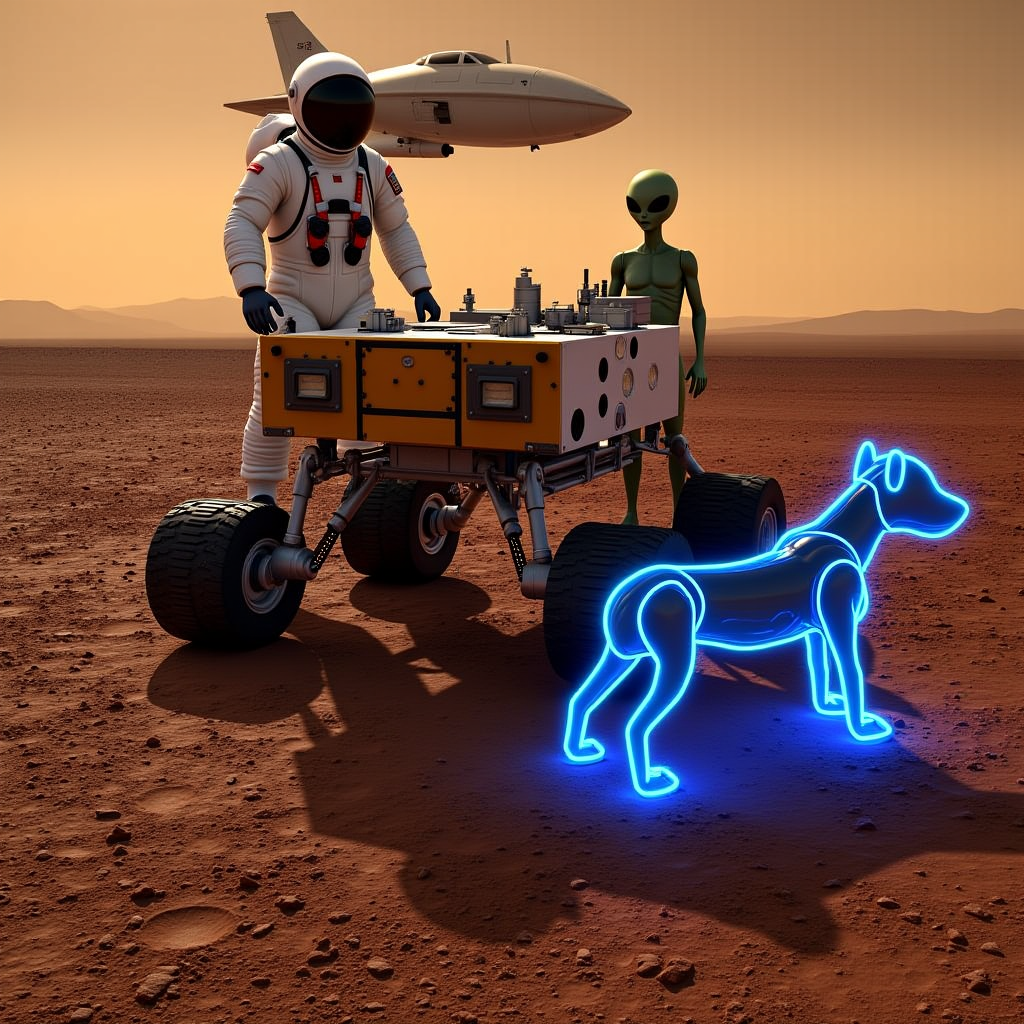

In [16]:
checkpoint = config.CHECKPOINT_NAMES[0]
for pkl_path in SCENE_PICKLE_PATHS:
    image = process_scene(pkl_path, checkpoint_name=checkpoint)
    if image:
        print(f"Success for {pkl_path}:")
        display(image)
        basename = os.path.basename(pkl_path).replace('.pkl', '.jpg')
        image.save(basename)
    else:
        print(f"Skipping {pkl_path} due to error.\n")


### 7. Cleanup Background Backends

In [17]:
print("Starting cleanup...")
blender_process.terminate()
blender_process.wait()


Starting cleanup...


0